In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
#Read data files
test = pd.read_csv('../data/test.csv')
train = pd.read_csv('../data/train.csv')

# Functions that should be used in preprocessing

In [117]:
# This function converts unix time to date
def create_column_date(train):
    train['date'] = pd.to_datetime(train['ts_listen'],unit='s')
    return train
    
#This function removes rows that are < October 2016 (more or less, see below)
def filter_on_ts_listen(train): 
    threshold = 1477500000
    print("Threshold date:",datetime.fromtimestamp(threshold))
    return train[train['ts_listen'] > threshold]


train = create_column_date(train) #creates new column with date instead of unix time
train = filter_on_ts_listen(train) #removes all the lines before Flow lauching

Threshold date: 2016-10-26 18:40:00


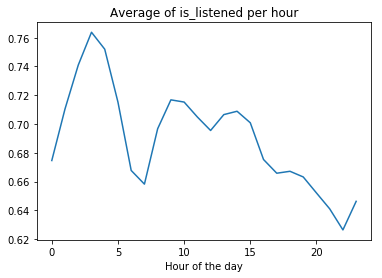

hour
0     0.674597
1     0.710526
2     0.740981
3     0.763821
4     0.752034
5     0.715208
6     0.667703
7     0.658185
8     0.696712
9     0.716799
10    0.715266
11    0.704881
12    0.695499
13    0.706541
14    0.708872
15    0.700857
16    0.675320
17    0.665777
18    0.667120
19    0.663186
20    0.652057
21    0.641013
22    0.626347
23    0.646227
Name: is_listened, dtype: float64


In [123]:
#This function adds a column to the train set, which is the average is_listened per hour of the day
def create_column_avg_is_listened_per_hour(train): 
    train['hour'] = train['date'].dt.hour
    avg_is_listened_per_hour = train.groupby(['hour'])['is_listened'].mean()
    
    #I think that there is a faster way for these 3 lines (join tables ?)
    #ACTUALLY THE CODE IS TOO SLOW. NEED TO MAKE IT FAST
    def predict_is_listened(row):
        return avg_is_listened_per_hour[row['hour']]
    train['avg_is_listened_per_hour'] = train.apply(lambda row: predict_is_listened(row),axis=1)
    
    return train,avg_is_listened_per_hour


train, avg_is_listened_per_hour = create_column_avg_is_listened_per_hour(train)

plt.plot(avg_is_listened_per_hour)
plt.title('Average of is_listened per hour')
plt.xlabel('Hour of the day')
plt.show()

print(avg_is_listened_per_hour)
print(train[avg_is_listened_per_hour])

# Explanation 1: why this filter function?

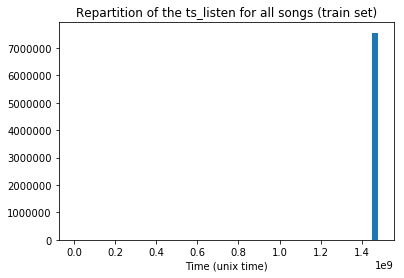

Oldest date (train): 1970-01-01 00:00:01
Most recent date (train): 2016-12-01 23:44:05


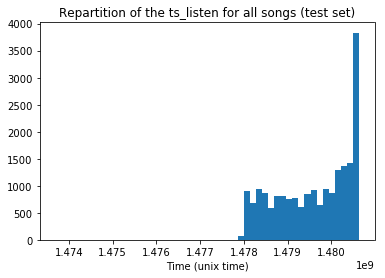

Oldest date (test): 2016-09-12 11:49:59
Most recent date (test): 2016-12-01 23:55:31


In [28]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')


#Train set: statistics

train['date'] = pd.to_datetime(train['ts_listen'],unit='s')
times_train = train['ts_listen']
dates_train = train['date']

plt.hist(times_train,bins=50)
plt.title('Repartition of the ts_listen for all songs (train set)')
plt.xlabel('Time (unix time)')
plt.show()

print("Oldest date (train):",dates_train.min())
print("Most recent date (train):",dates_train.max())


#Test set: statistics

test['date'] = pd.to_datetime(test['ts_listen'],unit='s')
times_test = test['ts_listen']
dates_test = test['date']

plt.hist(times_test,bins=50)
plt.title('Repartition of the ts_listen for all songs (test set)')
plt.xlabel('Time (unix time)')
plt.show()

print("Oldest date (test):",dates_test.min())
print("Most recent date (test):",dates_test.max())

## Statistics on the train and test sets

In [31]:
#Group by year
train['year'] = train.date.dt.year
print("Grouped by year")
print(train.groupby(['year']).size())

Grouped by year
year
1970        249
1980        379
1996          1
2001          2
2008         19
2009         96
2010          7
2011          7
2012          1
2013         19
2014          3
2015         29
2016    7558022
dtype: int64


In [32]:
#Now on the test set

#Group by year
test['year'] = test.date.dt.year
print("Grouped by year")
print(test.groupby(['year']).size())

Grouped by year
year
2016    19918
dtype: int64


Thus we choose to remove all rows before 2016 in the train set (all that is before is presumably tests).

In [63]:
# We interest ourselves to the users that are registered between 2010 and 2015 included

print('List of users:',train[(train['year'] >= 2010) & (train['year'] < 2016)]['user_id'].unique())
print()
print('Number of users:',len(train[(train['year'] >= 2010) & (train['year'] < 2016)]['user_id'].unique()))

#TODO: look if these users are 'special' people. Probably they were beta testers, or people working for Deezer

List of users: [ 9603  8808 10067 15841 10060  7805 18425 12301  2561  6596 12003 15901
  8876 14354 15445 11047 12872  2974  2096   332 19745 11576  9397]

Number of users: 23


We can see that there are not so many users (23 out of 19000) that listened to deezer between 2010 and 2016

In [66]:
#Same in the year 1970
print(train[train['year'] == 1970]['user_id'].unique())
print()
print('Number of users:',len(train[train['year'] == 1970]['user_id'].unique()))

[ 8627  5034 17416  3406  2196 12297 13719    89  2205  4606  6424 11362
 12936  7557 13183  6188 18023  7732  7516  1760 13875 13108 13165 10008
  7355  9776  1376  7255   218 19210 16840]

Number of users: 31


We can see that there are not so many users (31 out of 19000) that listened to deezer in 1970. 

Surprisingly, they are not the same as the ones between 2010 and 2016

In [71]:
train_filtered = train[train['year'] == 2016]

After removing all but 2016, we get:


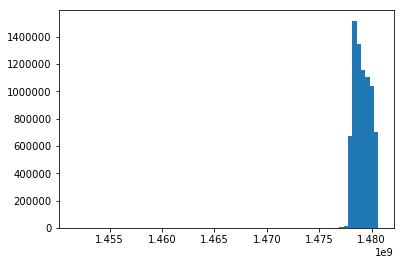

In [75]:
print("After removing all but 2016, we get:")
plt.hist(train_filtered['ts_listen'],bins=70)
plt.show()

Then we decide to remove until t = 1475000000 (unix time)

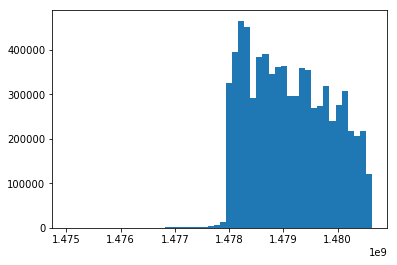

In [76]:
train_filtered = train[train['ts_listen'] > 1475000000]
plt.hist(train_filtered['ts_listen'],bins=50)
plt.show()

All that is before the peak is probably beta testing of the Flow mode (?). We choose to start at the peak

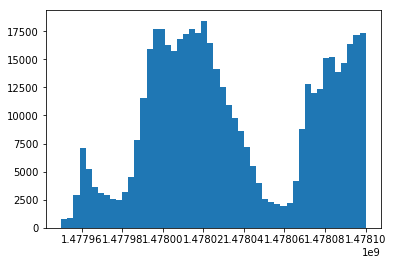

In [83]:
train_filtered = train[(train['ts_listen'] > 1477950000) & (train['ts_listen'] < 1478100000)]
plt.hist(train_filtered['ts_listen'],bins=50)
plt.show()

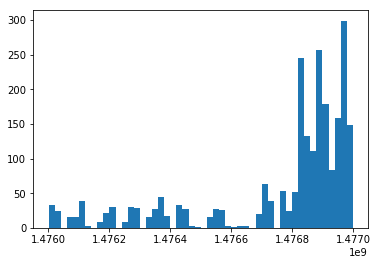

In [88]:
train_filtered = train[(train['ts_listen'] > 1476000000) & (train['ts_listen'] < 1477000000)]
plt.hist(train_filtered['ts_listen'],bins=50)
plt.show()

In [86]:
datetime.fromtimestamp(1477955000)

datetime.datetime(2016, 11, 1, 0, 3, 20)

In [87]:
#to check: is the test, for each user, exactly 1 month after the beginning of the train for this user ?
# Maybe Deezer chose 1 month for each user, simply

In [89]:
#TODO: Regarder si les stats changent entre la période de "beta testing" et ensuite. 
#Car il me semble que Flow a été lancé avant 2016. Il se pourrait que ce ne soit pas un beta testing de la 
#fonctionnalité Flow, mais juste un moyen de stocker les données qui soit testé, puis utilisé à grande échelle.

#Autre explication possible: On a 1 mois pile par utilisateur, donc le train commence 1 mois avant (or les 
#dates d'écoute diffèrent sur le test, donc le date de début du train diffère par utilisateur, ce qui explique
#les faible valeurs puis le pic)

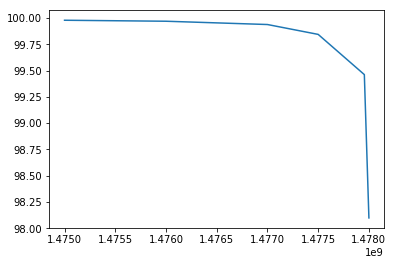

We keep 99.97814477735588 % of the data


In [105]:
list_thresholds = [1475000000,1476000000,1477000000,1477500000,1477955000,1478000000]
percent_kept = [100 * len(train[train['ts_listen'] > threshold]) / len(train) for threshold in list_thresholds]
plt.plot(list_thresholds,percent_kept)
plt.show()

print("We keep",100 * len(train[train['ts_listen'] > 1475000000]) / len(train),"% of the data")

The elbow is around 1.4775 1e9, so we take this threshold. We lose 0.02 % of the data, which is acceptable

# Explanation 2: Why the column avg_is_listened_per_hour?
## Temporal tendancies of is_listened: daily, hourly

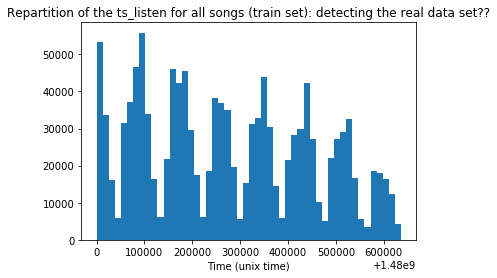

In [37]:
# Daily

threshold_plot = 1480000000

times_train_plot = train[train['ts_listen'] > threshold_plot]['ts_listen']
plt.hist(times_train_plot,bins=50)
plt.title('Repartition of the ts_listen for all songs (train set): detecting the real data set??')
plt.xlabel('Time (unix time)')
plt.show()

From 2016-11-01 12:33:20
To 2016-12-01 14:46:40


/home/vincent/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


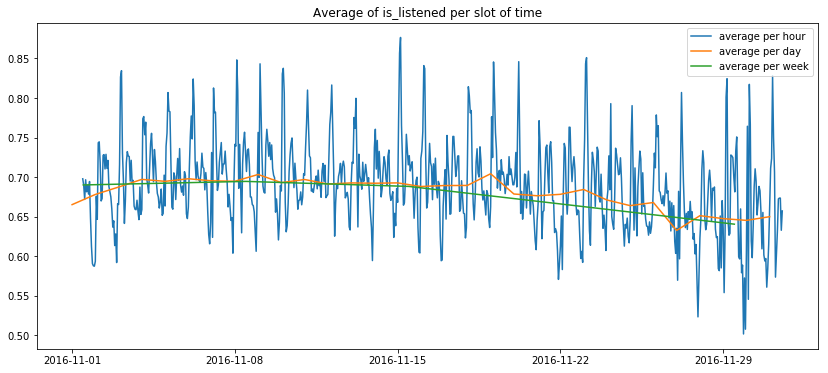

In [38]:
threshold_plot = 1478000000
print("From",datetime.fromtimestamp(threshold_plot))
threshold_plot_up = 1480600000 #1479000000
print("To",datetime.fromtimestamp(threshold_plot_up))

train_normal = train[(train['ts_listen'] > threshold_plot) & (train['ts_listen'] < threshold_plot_up)]
train_normal['date'] = pd.to_datetime(train_normal['ts_listen'],unit='s')

avg_per_hour = train_normal.set_index(['date']).groupby(pd.TimeGrouper('H'))['is_listened'].mean()
avg_per_day = train_normal.set_index(['date']).groupby(pd.TimeGrouper('D'))['is_listened'].mean()
avg_per_week = train_normal.set_index(['date']).groupby(pd.TimeGrouper('7D'))['is_listened'].mean()


plt.figure(figsize=(14, 6))
plt.plot(avg_per_hour,label='average per hour')
plt.plot(avg_per_day,label='average per day')
plt.plot(avg_per_week,label='average per week')
plt.title('Average of is_listened per slot of time')
plt.legend()
plt.show()

From 2016-11-01 12:33:20
To 2016-11-06 03:40:00


/home/vincent/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


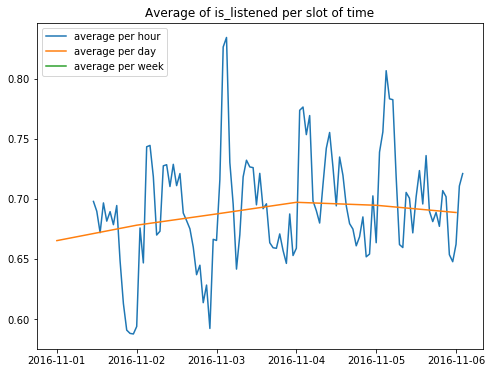

In [109]:
threshold_plot = 1478000000
print("From",datetime.fromtimestamp(threshold_plot))
threshold_plot_up = 1478400000
print("To",datetime.fromtimestamp(threshold_plot_up))

train_normal = train[(train['ts_listen'] > threshold_plot) & (train['ts_listen'] < threshold_plot_up)]
train_normal['date'] = pd.to_datetime(train_normal['ts_listen'],unit='s')

avg_per_hour = train_normal.set_index(['date']).groupby(pd.TimeGrouper('H'))['is_listened'].mean()
avg_per_day = train_normal.set_index(['date']).groupby(pd.TimeGrouper('D'))['is_listened'].mean()
avg_per_week = train_normal.set_index(['date']).groupby(pd.TimeGrouper('7D'))['is_listened'].mean()


plt.figure(figsize=(8, 6))
plt.plot(avg_per_hour,label='average per hour')
plt.plot(avg_per_day,label='average per day')
plt.plot(avg_per_week,label='average per week')
plt.title('Average of is_listened per slot of time')
plt.legend()
plt.show()

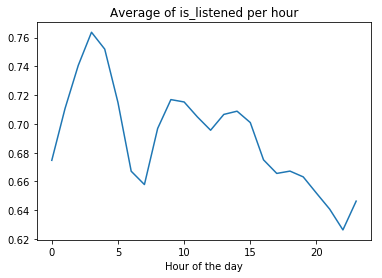

In [116]:
train['hour'] = train['date'].dt.hour
avg_is_listened_per_hour = train.groupby(['hour'])['is_listened'].mean()
plt.plot(avg_is_listened_per_hour)
plt.title('Average of is_listened per hour')
plt.xlabel('Hour of the day')
plt.show()


#TODO: RAJOUTER LES INTERVALLES DE CONFIANCE !!!!
# https://fr.wikipedia.org/wiki/Intervalle_de_confiance

# Influence of the age of the person

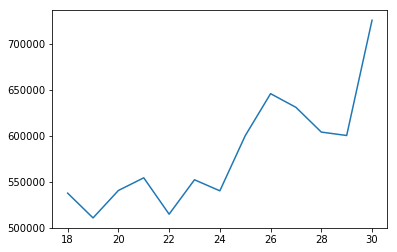

user_age
18    537853
19    511015
20    540783
21    554507
22    515061
23    552389
24    540401
25    600156
26    645781
27    630940
28    604114
29    600411
30    725423
dtype: int64


In [40]:
ages = sorted(train['user_age'].unique())
by_ages = train.groupby(['user_age']).size()
plt.plot(ages,by_ages)
plt.show()
print(by_ages)

In [34]:
train.groupby(['user_age'])['is_listened'].mean()

user_age
18    0.641099
19    0.642506
20    0.638909
21    0.653667
22    0.640258
23    0.652917
24    0.683457
25    0.675636
26    0.695191
27    0.706787
28    0.727219
29    0.745488
30    0.747569
Name: is_listened, dtype: float64

Conclusion: Keeping the age as it is, for decision trees, seems a good idea